# Basic Example for Calculating the Causal Effect
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and estimate the causal effect of a (pre-specified) treatment variable on a (pre-specified) outcome variable.

First, let us load all required packages.

In [108]:
import numpy as np

from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=5000, 
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)
df = data["df"]

In [109]:
import pandas as pd

In [110]:
df = pd.read_csv("bridge_binary_load.csv")

In [111]:
df.head()

,Unnamed: 0,input_rate,output_rate,latency,bridge_instructions,bridge_branches,bridge_branch-misses,bridge_branch-load-misses,bridge_cache-misses,bridge_cache-references,bridge_cycles,bridge_L1-dcache-load-misses,bridge_L1-dcache-loads,bridge_LLC-load-misses,bridge_LLC-stores,bridge_LLC-loads
0,0,528.196914,478.690020,17.210,2.289558e+09,454520501.0,1654144.0,1654091.0,2602.0,715.0,580098756.0,4923.0,720560636.0,25.0,0.0,6749.0
1,1,472.009050,528.257677,8.681,2.320473e+09,446293979.0,1636181.0,1650041.0,55.0,658.0,599325346.0,4829.0,744629626.0,63.0,0.0,463.0
2,2,527.940551,527.999645,7.770,2.483917e+09,489374524.0,1774572.0,1775378.0,25.0,469.0,617072261.0,9282.0,750112301.0,113.0,0.0,663.0
3,3,528.209734,528.260483,8.893,2.480397e+09,488851113.0,1773511.0,1772958.0,70.0,507.0,618348096.0,4816.0,769282198.0,13.0,75.0,5776.0
4,4,528.615025,528.568649,7.635,2.485589e+09,476514809.0,1734541.0,1734735.0,80.0,538.0,617847842.0,4826.0,766924105.0,125.0,0.0,438.0


Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Interface 1 (recommended): Input causal graph

We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

To create the causal graph for your dataset, you can use a tool like [DAGitty](http://dagitty.net/dags.html#) that provides a GUI to construct the graph. You can export the graph string that it generates. The graph string is very close to the DOT format: just rename `dag` to `digraph`, remove newlines and add a semicolon after every line, to convert it to the DOT format and input to DoWhy. 

# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

In [112]:
gml = """graph[
    directed 1
    node[ id "input_rate" label "input_rate"]
    node[ id "output_rate" label "output_rate"]
    node[ id "bridge_cycles" label "bridge_cycles"]
    node[ id "latency" label "latency"]
    node[ id "bridge_L1-dcache-load-misses" label "bridge_L1-dcache-load-misses"]
    edge[source "input_rate" target "output_rate"]
    edge[source "bridge_cycles" target "output_rate"]
    edge[source "bridge_cycles" target "latency"]
    edge[source "input_rate" target "latency"]
    edge[source "input_rate" target "bridge_L1-dcache-load-misses"]
    edge[source "bridge_L1-dcache-load-misses" target "output_rate"]
    edge[source "bridge_L1-dcache-load-misses" target "latency"]
]"""

In [113]:
data = df[["input_rate", "output_rate", "latency", "bridge_cycles", "bridge_L1-dcache-load-misses"]]
data

,input_rate,output_rate,latency,bridge_cycles,bridge_L1-dcache-load-misses
0,528.196914,478.690020,17.210,580098756.0,4923.0
1,472.009050,528.257677,8.681,599325346.0,4829.0
2,527.940551,527.999645,7.770,617072261.0,9282.0
3,528.209734,528.260483,8.893,618348096.0,4816.0
4,528.615025,528.568649,7.635,617847842.0,4826.0
...,...,...,...,...,...
944,528.120613,528.378804,4.845,617083039.0,379875.0
945,527.988512,527.936627,6.928,619019675.0,386194.0
946,528.272246,528.287872,4.870,619036199.0,372694.0
947,528.398485,528.284064,4.819,617153462.0,364988.0


In [114]:
model=CausalModel(
        data = data,
        treatment=["input_rate"],
        outcome="output_rate",
        graph=gml
        )

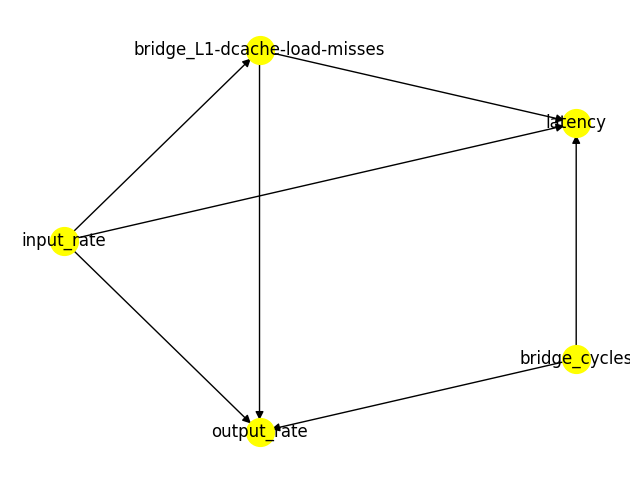

In [115]:
model.view_model()

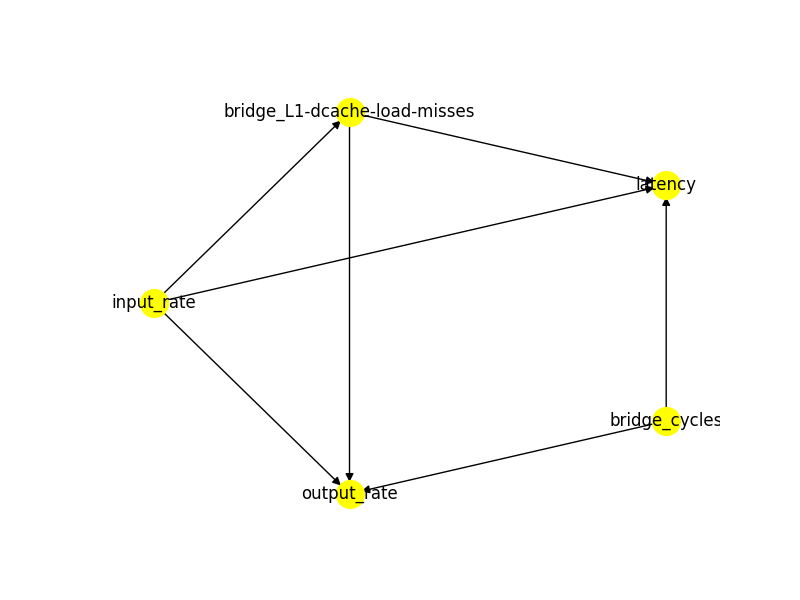

In [116]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

### DoWhy philosophy: Keep identification and estimation separate

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

#### Identification

In [117]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[outputᵣₐₜₑ])
d[inputᵣₐₜₑ]               
Estimand assumption 1, Unconfoundedness: If U→{input_rate} and U→output_rate then P(output_rate|input_rate,,U) = P(output_rate|input_rate,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Note the parameter flag *proceed\_when\_unidentifiable*. It needs to be set to *True* to convey the assumption that we are ignoring any unobserved confounding. The default behavior is to prompt the user to double-check that the unobserved confounders can be ignored. 

#### Estimation

In [118]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[outputᵣₐₜₑ])
d[inputᵣₐₜₑ]               
Estimand assumption 1, Unconfoundedness: If U→{input_rate} and U→output_rate then P(output_rate|input_rate,,U) = P(output_rate|input_rate,)

## Realized estimand
b: output_rate~input_rate+input_rate*bridge_cycles
Target units: ate

## Estimate
Mean value: 0.9915458079237514



You can input additional parameters to the estimate_effect method. For instance, to estimate the effect on any subset of the units, you can specify the "target_units" parameter which can be a string ("ate", "att", or "atc"), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify "effect modifiers" to estimate heterogeneous effects across these variables. See `help(CausalModel.estimate_effect)`. 

In [119]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        target_units="atc")

print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[outputᵣₐₜₑ])
d[inputᵣₐₜₑ]               
Estimand assumption 1, Unconfoundedness: If U→{input_rate} and U→output_rate then P(output_rate|input_rate,,U) = P(output_rate|input_rate,)

## Realized estimand
b: output_rate~input_rate+input_rate*bridge_cycles
Target units: atc

## Estimate
Mean value: 0.9915458079237514

Causal Estimate is 0.9915458079237514


In [120]:
df["input_rate"].corr(df["output_rate"])

In [121]:
df = pd.read_csv("l2fwd_random_load.csv")

gml = """graph[
    directed 1
    node[ id "input_rate" label "input_rate"]
    node[ id "output_rate" label "output_rate"]
    node[ id "l2fwd_cycles" label "l2fwd_cycles"]
    node[ id "latency" label "latency"]
    node[ id "l2fwd_L1-dcache-load-misses" label "l2fwd_L1-dcache-load-misses"]
    edge[source "input_rate" target "output_rate"]
    edge[source "l2fwd_cycles" target "output_rate"]
    edge[source "l2fwd_cycles" target "latency"]
    edge[source "input_rate" target "latency"]
    edge[source "input_rate" target "l2fwd_L1-dcache-load-misses"]
    edge[source "l2fwd_L1-dcache-load-misses" target "output_rate"]
    edge[source "l2fwd_L1-dcache-load-misses" target "latency"]
]"""

data = df[["input_rate", "output_rate", "latency", "l2fwd_cycles", "l2fwd_L1-dcache-load-misses"]]
data

,input_rate,output_rate,latency,l2fwd_cycles,l2fwd_L1-dcache-load-misses
0,7795.167880,5915.233979,13.485,580276770.0,14180.0
1,1209.088695,1350.851859,97.427,582654104.0,10561.0
2,2241.721515,2895.546122,58.294,617729279.0,5964.0
3,8173.779417,8002.005638,8.950,617765006.0,6093.0
4,6270.170190,5750.337259,15.290,615501307.0,10715.0
...,...,...,...,...,...
995,2510.830532,2686.797103,7.235,615959004.0,2890398.0
996,4178.571154,4155.320534,10.317,614911972.0,3080547.0
997,4520.757829,5055.422286,8.013,618969976.0,3635628.0
998,9172.273873,8783.775462,41.033,618929489.0,3152962.0


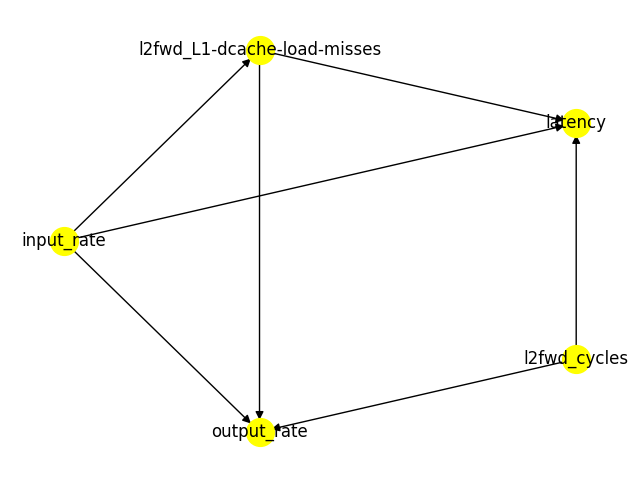

In [122]:
model=CausalModel(
        data = data,
        treatment=["input_rate"],
        outcome="output_rate",
        graph=gml
        )
model.view_model()

In [123]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[outputᵣₐₜₑ])
d[inputᵣₐₜₑ]               
Estimand assumption 1, Unconfoundedness: If U→{input_rate} and U→output_rate then P(output_rate|input_rate,,U) = P(output_rate|input_rate,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [124]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[outputᵣₐₜₑ])
d[inputᵣₐₜₑ]               
Estimand assumption 1, Unconfoundedness: If U→{input_rate} and U→output_rate then P(output_rate|input_rate,,U) = P(output_rate|input_rate,)

## Realized estimand
b: output_rate~input_rate+input_rate*l2fwd_cycles
Target units: ate

## Estimate
Mean value: 0.8931703417659946



In [128]:
df["input_rate"].corr(df["output_rate"], method="pearson")

In [126]:
df["input_rate"].corr(df["output_rate"], method="kendall")

In [127]:
df["input_rate"].corr(df["output_rate"], method="spearman")

In [130]:
df["input_rate"].corr(df["latency"])

In [131]:
df["input_rate"].corr(df["latency"], method="kendall")

In [132]:
df["input_rate"].corr(df["latency"], method="spearman")